In [2]:
!pip install datasets

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoModelForCausalLM
from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from datasets import load_dataset

ds = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from datasets import load_dataset

# loading the dataset
ds = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

train_data = ds["train"]  # training set
val_data = ds["validation"]  # vaalidation set
test_data = ds["test"]  # test set

# see if I imported them correctly:
print(train_data[0])
print(val_data[0])
print(test_data[0])


{'id': 9536, 'text': 'Cooking microwave pizzas, yummy', 'label': 2, 'sentiment': 'positive'}
{'id': 317, 'text': 'Laying in bed til workkk... Oh the life. Definitely pinched a nerve.', 'label': 0, 'sentiment': 'negative'}
{'id': 9235, 'text': 'getting cds ready for tour', 'label': 1, 'sentiment': 'neutral'}


Since RoBERTa performs bette on sentiment analysis I am going to use this model. it is slightly heavier that BERT (110M, 125M) but I prefer quality.


In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load dataset
ds = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")

#  train, validation, and test splits
train_data = ds["train"]
val_data = ds["validation"]
test_data = ds["test"]

# tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_function(examples):

    texts = [str(text) if text is not None else "" for text in examples["text"]]

    return tokenizer(texts, padding="max_length", truncation=True)

# Apply tokenization to all datasets
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_val = val_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

# Check after tokenization
print(tokenized_train[0])
print(tokenized_val[0])
print(tokenized_test[0])


Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

{'id': 9536, 'text': 'Cooking microwave pizzas, yummy', 'label': 2, 'sentiment': 'positive', 'input_ids': [0, 32963, 154, 28562, 26432, 281, 6, 1423, 22383, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [7]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": tokenized_train,
    "validation": tokenized_val,
    "test": tokenized_test
})

# check the structure
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5206
    })
})


In [8]:
#loading pretrained model
from transformers import AutoModelForSequenceClassification
num_labels = len(set(dataset["train"]["label"]))
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# data collator
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [10]:
# model arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/assignment",  # Save model here
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save model checkpoint at each epoch
    num_train_epochs=4,  # Updated: Increased from 2 to 4
    per_device_train_batch_size=16,  # Updated: Increased from 8 to 16
    per_device_eval_batch_size=16,  # Updated: Increased from 8 to 16
    save_total_limit=2,  # Keep only last 2 checkpoints
    learning_rate=2e-5,  # Updated: Decreased from 5e-5 to 2e-5
    logging_steps=2000,  # Keep logging interval
    resume_from_checkpoint=True,  # Resume training from checkpoint if available
    optim="adamw_torch",  # Updated: Use AdamW optimizer in PyTorch
    adam_beta1=0.9,  # Updated: Set AdamW beta1 to 0.9
    adam_beta2=0.999,  # Updated: Set AdamW beta2 to 0.999
    adam_epsilon=1e-08,  # Updated: Set AdamW epsilon to 1e-08
    lr_scheduler_type="linear",  # Updated: Use linear learning rate scheduler
)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-11-5319b4d4edfa>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: modelnlp16 (modelnlp16-mcmaster-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.570295
2,0.634400,0.561565
3,0.492900,0.626181
4,0.394500,0.705208


TrainOutput(global_step=7808, training_loss=0.4636399550516097, metrics={'train_runtime': 2624.031, 'train_samples_per_second': 47.609, 'train_steps_per_second': 2.976, 'total_flos': 3.2870233049923584e+16, 'train_loss': 0.4636399550516097, 'epoch': 4.0})

as we can see validation loss is increasing so here why ? because now the value of the rating rate is lower than before




In [13]:
trainer.evaluate(dataset["test"])


{'eval_loss': 0.6936375498771667,
 'eval_runtime': 34.3401,
 'eval_samples_per_second': 151.601,
 'eval_steps_per_second': 9.493,
 'epoch': 4.0}

now I want to check it performance on asample classification:

In [14]:
test_comments = [
    "This product is amazing! I love it!",   # Positive
    "Bloody awesome! never buying again!",  # Negative
    "It's okay, nothing special.",  # Neutral
    "Fantastic quality, exceeded my expectations!",  # Positive
    "Worst experience ever, I'm disappointed.",  # Negative
    "Not bad, but could be better.",  # Neutral
    "I had a wonderful time using this.",  # Positive
    "I don't like it at all.",  # Negative
    "Just an average experience, nothing to complain about.",  # Neutral
    "not the best purchase I’ve ever made!"  # negative
]


In [15]:
tokenized_inputs = tokenizer(test_comments, padding=True, truncation=True, return_tensors="pt")


In [16]:
import torch

# Get model outputs
with torch.no_grad():
    # Move tokenized_inputs to the same device as the model
    tokenized_inputs = tokenized_inputs.to(model.device)
    outputs = model(**tokenized_inputs)

# Convert logits to predictions
predictions = torch.argmax(outputs.logits, dim=-1)

# Print raw predictions
print(predictions)

tensor([2, 0, 1, 2, 0, 1, 2, 0, 1, 1], device='cuda:0')


In [17]:
# Define label mapping (update based on your dataset)
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Convert predictions to human-readable labels
predicted_labels = [label_mapping[pred.item()] for pred in predictions]

# Print results
for comment, sentiment in zip(test_comments, predicted_labels):
    print(f"Comment: {comment}\nPredicted Sentiment: {sentiment}\n")


Comment: This product is amazing! I love it!
Predicted Sentiment: Positive

Comment: Absolutely terrible, never buying again!
Predicted Sentiment: Negative

Comment: It's okay, nothing special.
Predicted Sentiment: Neutral

Comment: Fantastic quality, exceeded my expectations!
Predicted Sentiment: Positive

Comment: Worst experience ever, I'm disappointed.
Predicted Sentiment: Negative

Comment: Not bad, but could be better.
Predicted Sentiment: Neutral

Comment: I had a wonderful time using this.
Predicted Sentiment: Positive

Comment: I don't like it at all.
Predicted Sentiment: Negative

Comment: Just an average experience, nothing to complain about.
Predicted Sentiment: Neutral

Comment: not the best purchase I’ve ever made!
Predicted Sentiment: Neutral



As we can see the model is doing well! it classified all the texts correctly

In [18]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)  # Convert logits to class predictions

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [20]:
trainer.compute_metrics = compute_metrics

# Evaluate on the test set
eval_results = trainer.evaluate(dataset["test"])

# Print results
print("Evaluation Results:", eval_results)


Evaluation Results: {'eval_loss': 0.6936375498771667, 'eval_accuracy': 0.774490971955436, 'eval_precision': 0.7732882550516349, 'eval_recall': 0.774490971955436, 'eval_f1': 0.7736399249535288, 'eval_runtime': 34.9517, 'eval_samples_per_second': 148.948, 'eval_steps_per_second': 9.327, 'epoch': 4.0}


benchmarking: on Hugging face I found this results: eval_loss: 0.8834
eval_accuracy: 0.7655
eval_precision: 0.7636
eval_recall: 0.7655
eval_f1: 0.7635
eval_runtime: 24.6425
eval_samples_per_second: 211.261
eval_steps_per_second: 13.229 the results are comparatively better than mine so i try to change the model arguments to see a better result. Because of the limited resources that I have I couldn't train it more than  4 epochs but based on the benchmarks I found on this specific dataset and using RoBERTa, by keeping the learning rate at 2e-5 and increase the number of epiochs accuracy will increase. in the next steps I would like to see by using LoRa how the results will change.



In [21]:
!pip install scikit-learn matplotlib seaborn
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [22]:
import torch
from tqdm import tqdm  # import tqdm for progress bar

# move tokenized test dataset to correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract inputs and labels from the tokenized test dataset
input_ids = torch.tensor(tokenized_test["input_ids"]).to(device)
attention_mask = torch.tensor(tokenized_test["attention_mask"]).to(device)
true_labels = tokenized_test["label"]

# set batch size for prediction
batch_size = 32
# predictions list
all_predictions = []

# Iterate over the dataset in batches
for i in tqdm(range(0, len(tokenized_test), batch_size)):
    # Get a batch of inputs
    batch_input_ids = input_ids[i : i + batch_size]
    batch_attention_mask = attention_mask[i : i + batch_size]

    # Get predictions for the batch
    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # Add batch predictions to the list
    all_predictions.extend(batch_predictions)

# Convert the list of predictions to a NumPy array
predictions = np.array(all_predictions)



100%|██████████| 163/163 [00:29<00:00,  5.55it/s]


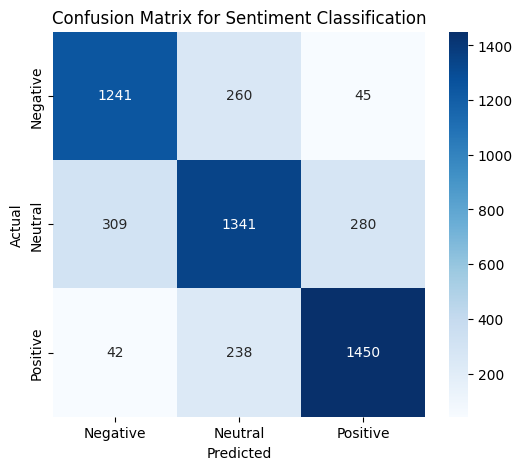

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class names
class_names = ["Negative", "Neutral", "Positive"]  # Update if needed

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Sentiment Classification")
plt.show()


In [24]:
test_sentence = "I really don't know to react to this product it is not good and not bad"


In [25]:
# tokenizeing the test_sentence
inputs = tokenizer(test_sentence, return_tensors="pt").to(device)

#  attention scores
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

#  attention weights from the last layer
attention_weights = outputs.attentions[-1]  # Last layer
attention_weights = attention_weights.mean(dim=1).squeeze().cpu().numpy()  # Average over all heads


RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


the confusion matrix shows strong Performance for in positive and negative Classes.
Negative class: 1,241 correct predictions out of 1,546 total ( 77.8% accuracy for negative class).
Positive class: 1,450 correct predictions out of 1,730 total (83.6% accuracy for positive class).
But unfortunately, it does not do well for neutral class
it is often confused with both Negative (309) and Positive (280).
The model struggles to differentiate between neutral and slightly positive ornegative sentiments.
By using LoRa I want to make the results better.

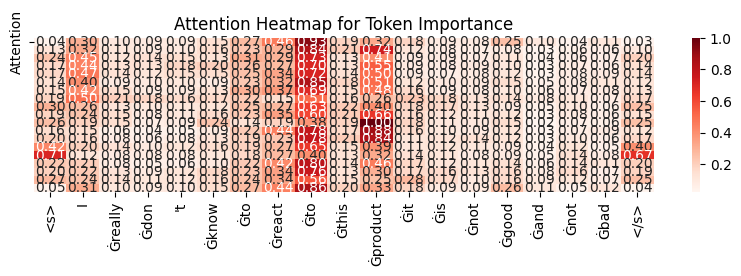

In [26]:
import numpy as np

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().cpu().numpy())

# normalizing attention scores
attention_weights = outputs.attentions[-1][0, 0, :].cpu().numpy()  # [batch_index, head_index, token_index]
attention_weights = attention_weights / np.max(attention_weights)  # Normalize to range [0,1]

# Reshape attention_weights to 2D for heatmap
attention_weights_2d = attention_weights.reshape(attention_weights.shape[0], -1) # Reshape to (19, 19)

# Plot heatmap
plt.figure(figsize=(10, 2))
# Pass attention_weights_2d to data and annot
sns.heatmap(attention_weights_2d, annot=attention_weights_2d, cmap="Reds", xticklabels=tokens, yticklabels=["Attention"], fmt=".2f")
plt.title("Attention Heatmap for Token Importance")
plt.show()